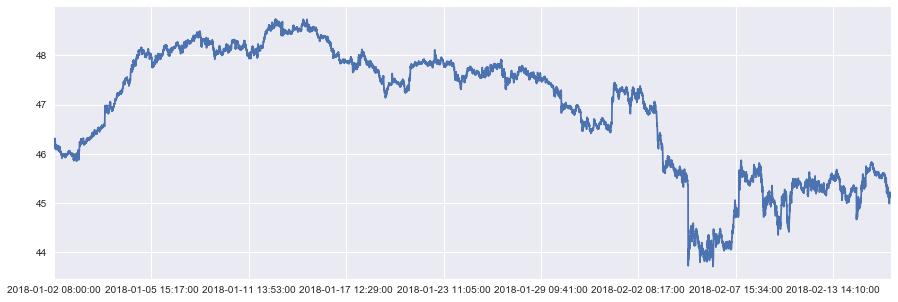

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

import networkx as nx
from statsmodels.tsa.stattools import adfuller

# read the data
# data = pd.read_csv('closing_prices_cleaned.csv')
data = pd.read_csv('closing_prices_cleaned.csv', index_col=0)

data.head()

plt.figure(figsize=(15,5))
data['FP FP Equity'].plot()

In [93]:
# Get returns / log_returns from pricing data
# rtn = data.pct_change()[1:]
rtn = data.pct_change()
log_rtn = np.log(rtn + 1)
price = np.exp(log_rtn.cumsum()) -1
rtn = rtn.iloc[1:]
log_rtn = log_rtn.iloc[1:]
price = price.iloc[1:]

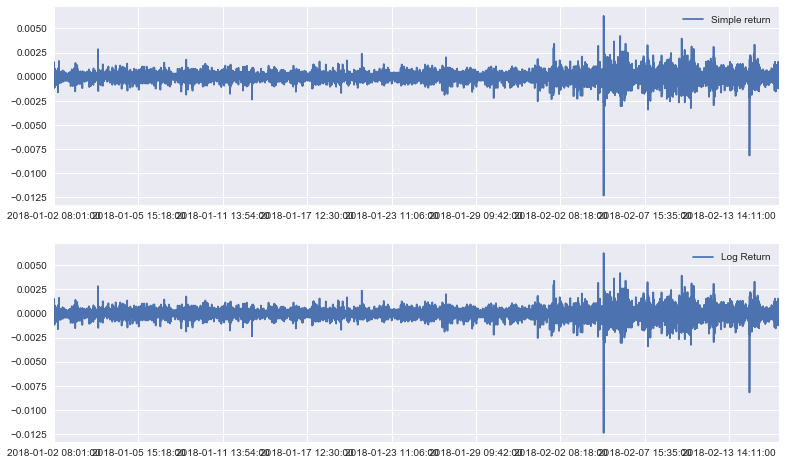

In [95]:
plt.figure(figsize=(13,8))
plt.subplot(211)
rtn['FP FP Equity'].plot(label='Simple return', legend=True)
plt.subplot(212)
log_rtn['FP FP Equity'].plot(label='Log Return', legend=True)

## Agumented Dick-Fuller test
Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be accepted or rejected. The result must be interpreted for a given problem to be meaningful.

Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [96]:
# remove the first entry cause it is NaN
resultLog = adfuller(log_rtn['DBK GR Equity'], regression='ctt')
resultData = adfuller(data['DBK GR Equity'], regression='ctt')

In [97]:
print('ADF Statistic (log-return): %f' % resultLog[0])
print('p-value (log-return): %f' % resultLog[1])
print('ADF Statistic: %f' % resultData[0])
print('p-value: %f' % resultData[1])
print('Critical Values:')
for key, value in resultData[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic (log-return): -79.300882
p-value (log-return): 0.000000
ADF Statistic: -1.711670
p-value: 0.905325
Critical Values:
	1%: -4.372
	5%: -3.833
	10%: -3.553


Accordingly to the ADF test, it looks like the original data isn't stationary, but log-returns are!! 
Somehow if I plot the autoregressive coeff for different legs I still see some time dependence. Is it normal?

Of course I'm expecting time dependency for the time series of prices, but the following ACF is a bit weird. I would have expected exponentially decaying time dependency... it is instead almost constant ~1

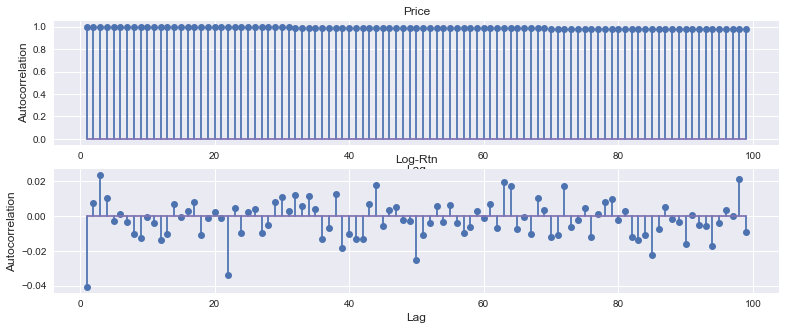

In [98]:
lags = range(1, 100)
autocorrs = [log_rtn['BBVA SM Equity'].autocorr(lag=lag) 
                   for lag in lags]
autocorrsData = [data['BBVA SM Equity'].autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(13, 5))
plt.subplot(211)
plt.stem(lags, autocorrsData)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.title('Price')
plt.subplot(212)
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.title('Log-Rtn')

Anywyay let's assume we have stationary data now... we can observe volatility clustering in the log_returns and we could remove that part too deploying a GARCH model... shall we???

## VAR Model
With stationary data we can now make a VAR model

In [99]:
# make a VAR model
model = VAR(log_rtn)

In [102]:
model.select_order()

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -724.6       -724.5   2.142e-315       -724.5
1        -725.9      -724.8*   5.590e-316       -725.5
2        -726.4       -724.3   3.398e-316      -725.7*
3        -726.7       -723.5   2.622e-316       -725.6
4        -726.9       -722.7   2.116e-316       -725.5
5        -727.0       -721.8   1.809e-316       -725.3
6        -727.1       -720.8   1.744e-316       -725.0
7        -727.1       -719.8   1.701e-316       -724.7
8        -727.1       -718.8   1.659e-316       -724.4
9        -727.1       -717.7   1.638e-316       -724.0
10      -727.1*       -716.7  1.612e-316*       -723.7
11       -727.1       -715.6   1.640e-316       -723.3
12       -727.1       -714.6   1.669e-316       -723.0
13       -727.1       -713.5   1.709e-316       -722.6
14       -727.1       -712.5   1.744e-316       -722.3
15       -

{'aic': 10, 'bic': 1, 'fpe': 10, 'hqic': 2}

In [108]:
VARresults = model.fit(maxlags=1, ic='bic')

In [109]:
VARresults.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Apr, 2018
Time:                     18:01:46
--------------------------------------------------------------------
No. of Equations:         48.0000    BIC:                   -724.629
Nobs:                     17191.0    HQIC:                  -725.340
Log likelihood:       5.06916e+06    FPE:               6.86941e-316
AIC:                     -725.690    Det(Omega_mle):    5.99219e-316
--------------------------------------------------------------------
Results for equation BNP FP Equity
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.000001         0.000005            0.273           0.785
L1.BNP FP Equity          0.011864         0.012686            0.935           0.350
L1.CA FP Equity           0.010820  

In [162]:
corrMat = pd.DataFrame(VARresults.resid_corr, columns=VARresults.names, index=VARresults.names)
corrMat

BNP FP Equity  CA FP Equity  CRH ID Equity  DAI GR Equity  \
BNP FP Equity        1.000000      0.191964       0.217538       0.078031   
CA FP Equity         0.191964      1.000000       0.158810       0.045596   
CRH ID Equity        0.217538      0.158810       1.000000       0.024699   
DAI GR Equity        0.078031      0.045596       0.024699       1.000000   
BN FP Equity         0.290624      0.222910       0.251658       0.059114   
DBK GR Equity        0.056676      0.031738       0.019610       0.413669   
DTE GR Equity        0.045228      0.044041       0.024759       0.423823   
ENEL IM Equity       0.251964      0.156563       0.181369       0.115991   
ENGI FP Equity       0.324111      0.214373       0.210604       0.061835   
ENI IM Equity        0.306225      0.179048       0.196883       0.099392   
EOAN GR Equity       0.056751      0.033944       0.004711       0.465789   
EI FP Equity         0.270273      0.202972       0.224022       0.022247   
IBE SM Equity        0.238850      0.171131       0.185299       0.071956   
ITX SM Equity        0.223984      0.187077       0.199254       0.043366   
INGA NA Equity       0.664675      0.174887       0.213965       0.162457   
ISP IM Equity        0.475487      0.154649       0.175087       0.067005   
OR FP Equity         0.274065      0.220849       0.256874       0.020725   
MC FP Equity         0.318714      0.219357       0.278826       0.041273   
MUV2 GR Equity       0.043252      0.020778       0.012026       0.426109   
ORA FP Equity        0.300508      0.222851       0.228331       0.039279   
PHIA NA Equity       0.364411      0.211997       0.253431       0.106310   
REP SM Equity        0.275847      0.152430       0.178654       0.073556   
RWE GR Equity        0.040912      0.023592       0.016050       0.281168   
SGO FP Equity        0.437173      0.254098       0.337806       0.060477   
SAN FP Equity        0.292924      0.182980       0.217257       0.021462   
SAP GR Equity        0.061918      0.054752       0.031148       0.561962   
SU FP Equity         0.391769      0.236385       0.281440       0.065889   
SIE GR Equity        0.035403      0.038274       0.000560       0.435797   
GLE FP Equity        0.696207      0.176438       0.210351       0.061022   
TEF SM Equity        0.356794      0.210177       0.233817       0.020974   
FP FP Equity         0.386663      0.227856       0.252969       0.112096   
UCG IM Equity        0.477085      0.128465       0.140873       0.266436   
ULVR LN Equity       0.160323      0.181596       0.180400       0.065656   
DG FP Equity         0.322020      0.210303       0.256860       0.063129   
VIV FP Equity        0.195243      0.126477       0.166185       0.014565   
VOW GR Equity        0.008564      0.032590      -0.011182       0.311016   
AI FP Equity         0.374594      0.230843       0.288886       0.062610   
ALV GR Equity        0.070970      0.040655       0.018092       0.664679   
ABI BB Equity        0.309327      0.197744       0.242124       0.133747   
MTS SM Equity        0.252592      0.124690       0.187946       0.053738   
ASML NA Equity       0.256535      0.180309       0.217295       0.093305   
G IM Equity          0.345088      0.148454       0.157999       0.059208   
CS FP Equity         0.557313      0.233707       0.251155       0.065078   
BBVA SM Equity       0.624628      0.182233       0.213296       0.019809   
SAN SM Equity        0.637934      0.184765       0.224680       0.028040   
BAS GR Equity        0.043920      0.048437       0.004729       0.428089   
BAYN GR Equity       0.061132      0.055668       0.029476       0.599994   
BMW GR Equity        0.065204      0.050561       0.029849       0.740655   

                BN FP Equity  DBK GR Equity  DTE GR Equity  ENEL IM Equity  \
BNP FP Equity       0.290624       0.056676       0.045228        0.251964   
CA FP Equity        0.222910       0.031738       0.044041        0.156563   
CRH ID E

In [163]:
# Transform it in a links data frame (3 columns only):
links = corrMat.stack().reset_index()
links.columns = ['var1', 'var2','value']
links

var1            var2     value
0     BNP FP Equity   BNP FP Equity  1.000000
1     BNP FP Equity    CA FP Equity  0.191964
2     BNP FP Equity   CRH ID Equity  0.217538
3     BNP FP Equity   DAI GR Equity  0.078031
4     BNP FP Equity    BN FP Equity  0.290624
5     BNP FP Equity   DBK GR Equity  0.056676
6     BNP FP Equity   DTE GR Equity  0.045228
7     BNP FP Equity  ENEL IM Equity  0.251964
8     BNP FP Equity  ENGI FP Equity  0.324111
9     BNP FP Equity   ENI IM Equity  0.306225
10    BNP FP Equity  EOAN GR Equity  0.056751
11    BNP FP Equity    EI FP Equity  0.270273
12    BNP FP Equity   IBE SM Equity  0.238850
13    BNP FP Equity   ITX SM Equity  0.223984
14    BNP FP Equity  INGA NA Equity  0.664675
15    BNP FP Equity   ISP IM Equity  0.475487
16    BNP FP Equity    OR FP Equity  0.274065
17    BNP FP Equity    MC FP Equity  0.318714
18    BNP FP Equity  MUV2 GR Equity  0.043252
19    BNP FP Equity   ORA FP Equity  0.300508
20    BNP FP Equity  PHIA NA Equity  0.364411
21    BNP FP Equity   REP SM Equity  0.275847
22    BNP FP Equity   RWE GR Equity  0.040912
23    BNP FP Equity   SGO FP Equity  0.437173
24    BNP FP Equity   SAN FP Equity  0.292924
25    BNP FP Equity   SAP GR Equity  0.061918
26    BNP FP Equity    SU FP Equity  0.391769
27    BNP FP Equity   SIE GR Equity  0.035403
28    BNP FP Equity   GLE FP Equity  0.696207
29    BNP FP Equity   TEF SM Equity  0.356794
...             ...             ...       ...
2274  BMW GR Equity  MUV2 GR Equity  0.417402
2275  BMW GR Equity   ORA FP Equity  0.039492
2276  BMW GR Equity  PHIA NA Equity  0.100880
2277  BMW GR Equity   REP SM Equity  0.058570
2278  BMW GR Equity   RWE GR Equity  0.298358
2279  BMW GR Equity   SGO FP Equity  0.056830
2280  BMW GR Equity   SAN FP Equity  0.017689
2281  BMW GR Equity   SAP GR Equity  0.548246
2282  BMW GR Equity    SU FP Equity  0.047521
2283  BMW GR Equity   SIE GR Equity  0.473633
2284  BMW GR Equity   GLE FP Equity  0.051403
2285  BMW GR Equity   TEF SM Equity  0.034924
2286  BMW GR Equity    FP FP Equity  0.111525
2287  BMW GR Equity   UCG IM Equity  0.237097
2288  BMW GR Equity  ULVR LN Equity  0.058922
2289  BMW GR Equity    DG FP Equity  0.070141
2290  BMW GR Equity   VIV FP Equity  0.020990
2291  BMW GR Equity   VOW GR Equity  0.364319
2292  BMW GR Equity    AI FP Equity  0.078916
2293  BMW GR Equity   ALV GR Equity  0.616258
2294  BMW GR Equity   ABI BB Equity  0.124840
2295  BMW GR Equity   MTS SM Equity  0.051196
2296  BMW GR Equity  ASML NA Equity  0.084391
2297  BMW GR Equity     G IM Equity  0.035084
2298  BMW GR Equity    CS FP Equity  0.065316
2299  BMW GR Equity  BBVA SM Equity  0.022093
2300  BMW GR Equity   SAN SM Equity  0.031449
2301  BMW GR Equity   BAS GR Equity  0.459242
2302  BMW GR Equity  BAYN GR Equity  0.550390
2303  BMW GR Equity   BMW GR Equity  1.000000

[2304 rows x 3 columns]

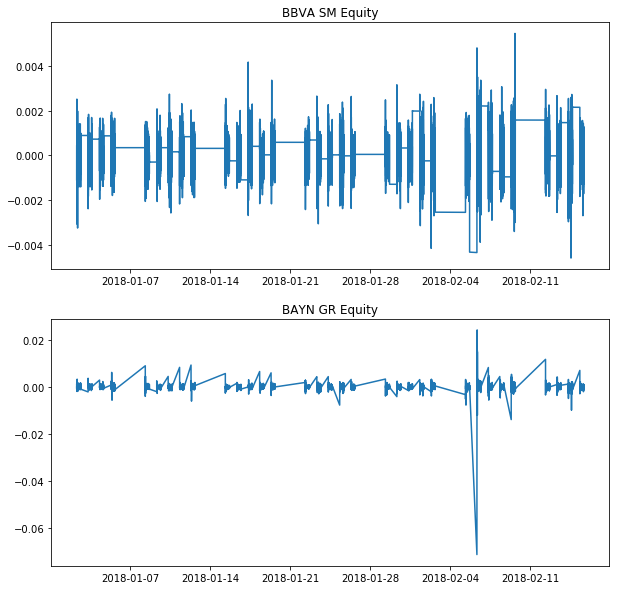

In [86]:
VARresults.plot()

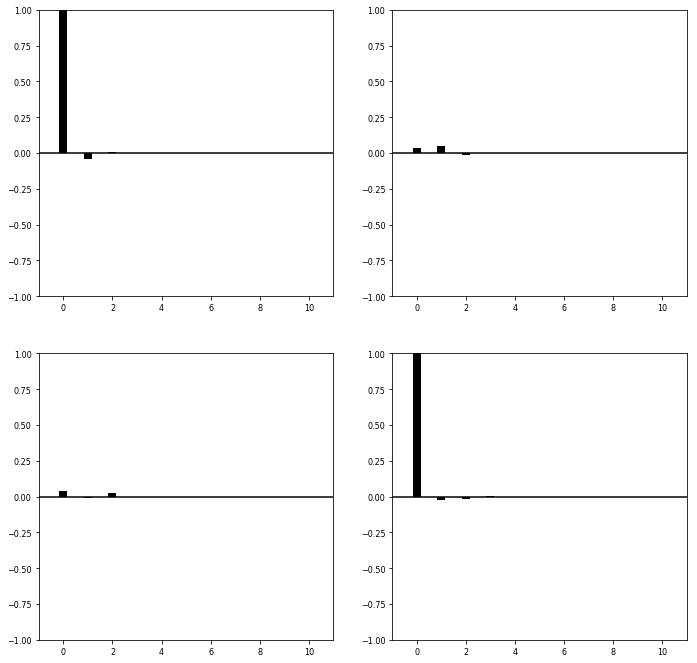

In [88]:
VARresults.plot_acorr()

In [89]:
VARresults.test_normality()

Normality skew/kurtosis Chi^2-test
     Test statistic   Critical Value          p-value  df
---------------------------------------------------------
  3521278906.961972         9.487729            0.000   4
H_0: data generated by normally-distributed process
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 9.487729036781154,
 'df': 4,
 'pvalue': 0.0,
 'signif': 0.05,
 'statistic': 3521278906.9619718}

FAIL: Some autocorrelations exceed 0.0153 bound. See plot


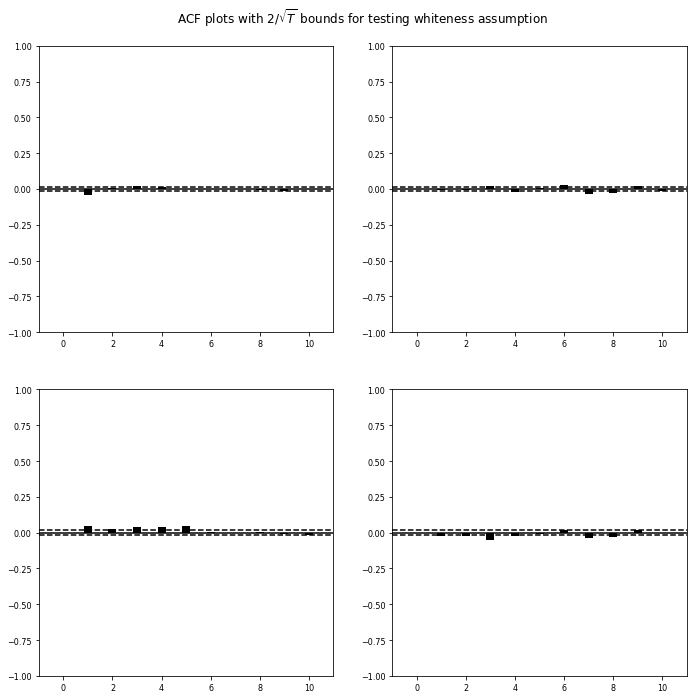

In [91]:
VARresults.test_whiteness()

In [93]:
VARresults.test_causality('BBVA SM Equity', 'BAYN GR Equity', kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value          df
---------------------------------------------------------------
         1.550436         2.995993            0.212  (2, 34368)
H_0: ['BAYN GR Equity'] do not Granger-cause BBVA SM Equity
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 2.995993415707408,
 'df': (2, 34368),
 'pvalue': 0.21217029667831247,
 'signif': 0.05,
 'statistic': 1.5504359808262878}

In [94]:
irf = VARresults.irf(10)

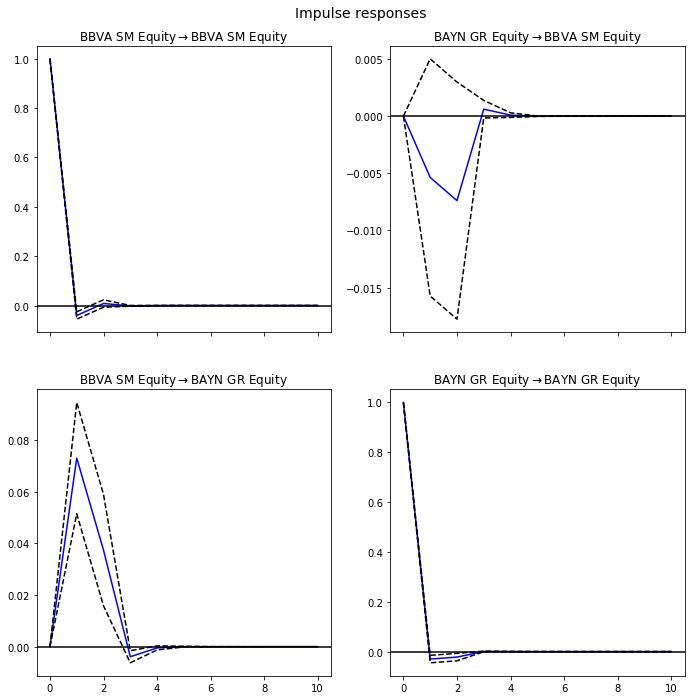

In [95]:
irf.plot(orth=False)

In [6]:
from statsmodels.api import tsa

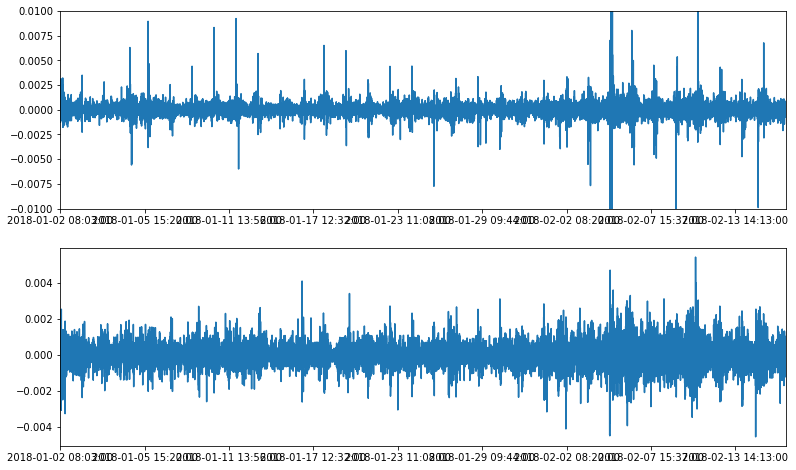

In [26]:
plt.figure(figsize=(13,8))
plt.subplot(211)
VARresults.resid['BAYN GR Equity'].plot()
plt.ylim([-0.01, 0.01])
plt.subplot(212)
VARresults.resid['BBVA SM Equity'].plot()

In [30]:
resid = VARresults.resid['BAYN GR Equity']
stats.normaltest(resid)

NormaltestResult(statistic=42981.824150222019, pvalue=0.0)

In [31]:
resid = VARresults.resid['BBVA SM Equity']
stats.normaltest(resid)

NormaltestResult(statistic=1732.8947582561464, pvalue=0.0)

(-0.005, 0.005)

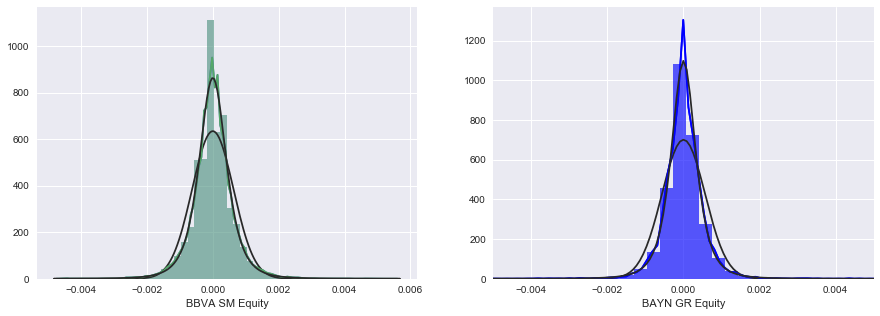

In [85]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(VARresults.resid['BBVA SM Equity'], kde=True, fit=stats.norm)
sns.distplot(VARresults.resid['BBVA SM Equity'], kde=True, fit=stats.t)
plt.subplot(122)
# only until 13000 to remove the extremes...
sns.distplot(VARresults.resid['BAYN GR Equity'][:13000], kde=True, fit=stats.norm, color='b')
sns.distplot(VARresults.resid['BAYN GR Equity'][:13000], kde=True, fit=stats.t, color='b')
plt.xlim([-.005, .005])

It looks like our residuals are distributed as a t-student!

# Represent on a Graph

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


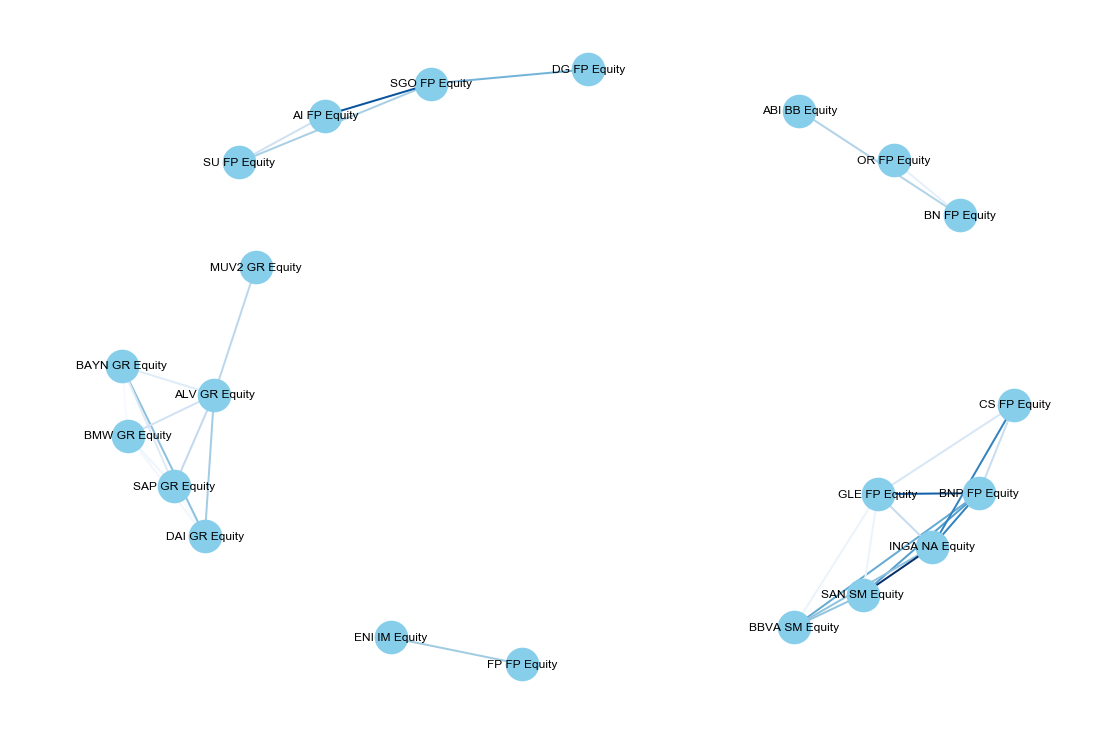

In [172]:
### Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] > 0.5) & (links['var1'] != links['var2']) ]
links_filtered

# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'var1', 'var2', create_using=nx.Graph() )

# Plot the network:
# if the graph is not directed you gotta need to drop duplicates in the edge_color cause
# links_filtered['value'] includes A->B and B->A while not directed graph cares only about 
# one between A->B or B->A
plt.figure(figsize=(15,10))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, linewidths=2, 
        font_size=12, edge_color=links_filtered['value'].drop_duplicates(), width=2.0, edge_cmap=plt.cm.Blues)

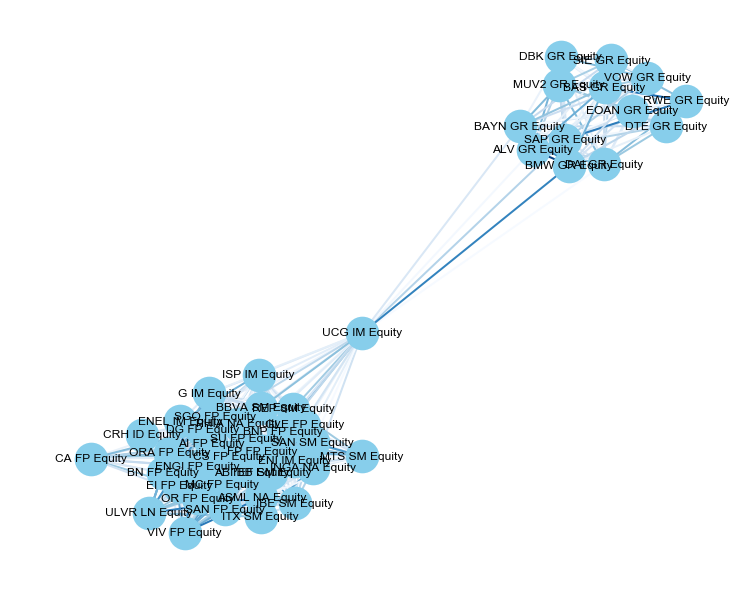

In [177]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def graph_plot(Threshold):
    plt.figure(figsize=(10,8))
    
    links_filtered=links.loc[ (links['value'] > Threshold) & (links['var1'] != links['var2']) ]
    links_filtered

    # Build your graph
    G=nx.from_pandas_dataframe(links_filtered, 'var1', 'var2', create_using=nx.Graph() )

    # Plot the network:
    # if the graph is not directed you gotta need to drop duplicates in the edge_color cause
    # links_filtered['value'] includes A->B and B->A while not directed graph cares only about 
    # one between A->B or B->A
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, linewidths=2, 
            font_size=12, edge_color=links_filtered['value'].drop_duplicates(), width=2.0, edge_cmap=plt.cm.Blues)
    
    plt.legend();
    plt.show()

interact(graph_plot, Threshold=(-1.0, 1.0));